# Pràctica 3: Regressió Logistica



# Objectius de la Pràctica

Els diferents objectius d'aquesta pràctica és que us comenceu a familiaritzar amb casos de classificació (tant binaria com multiclass). Per aquest motiu respecte a la pràctica haureu d'entendre:

1. Generar un model de regressió Logística i entendre els diferents paràmetres que hi han i per a que serveixen
2. Entendre com regularitzar el overfitting i el underfitting del model (entendre errors de variance, bias...)
3. Entendre com cercar i evaluar el millor model 
4. Estratègies de validació i entrenament multiclass (Ovo, Ovr)

## Introducció

Per implementar una regressió logística, necessito una funció d'hipòtesi $h_{\theta}(x)$
, una funció de cost $J(\theta)$ , i una funció de degradat que calcula les derivades parcials de $J(\theta)$.

En regressió logística,$h_{\theta}(x)$ és la funció sigmoide. La funció sigmoide està fitada entre 0 i 1, i produeix un valor que es pot interpretar com una probabilitat. Aquest valor també pot ser una resposta sí / no amb un creuament, o un límit de decisió, a 0,5:

$$
h_{\theta}(x) = \frac{1}{1+e^{\theta_x}}
$$


L'ús del MSE de la regressió lineal no és una bona idea aquí, ja que la funció de cost resultant no és convexa i, per tant, no és adequada per al descens de gradient. En canvi, la diferència de $h_{\theta}(x^i)-y^i$ es calcula de manera diferent per y=0 & y=1 i el resultat es transforma logarítmicament en una funció convexa:

$$
J(\theta) = \frac{1}{m} \cdot \sum_{i=1}^m y^i log(h_{\theta}(x^i)) + (1-y^i)log(1-h_{\theta}(x^i))
$$

tot i així la derivada es comporta de manera idèntica només que la funció de cost es diferent.

Anem a veure un exemple més visual de com es comporta el regressor

(-2.5529898158340787, 2.2697546239876076)

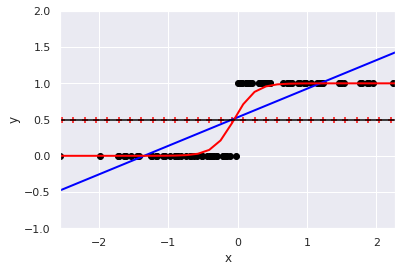

In [342]:
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
#definim la funció de la sigmoide
logistic = lambda s: 1.0 / (1.0 + np.exp(-s))

xmin, xmax = -10, 10
np.random.seed(0)
d = 0
X = np.random.normal(size = 100) + d
xmin, xmax = X.min(), X.max()

y = (X > d).astype(float) 
X = X[:, np.newaxis] 
X_test = np.linspace(-4, 4, 50)

# Linear Regression:
rgr = linear_model.SGDRegressor( learning_rate='constant', eta0=0.01)
rgr.fit(X, y)
plt.plot(X_test, rgr.coef_.ravel() * X_test + rgr.intercept_, color = 'blue', linewidth = 2)

# Logistic Regression:
clf = linear_model.SGDClassifier(learning_rate='constant', eta0=0.05, max_iter=1000000)
clf.fit(X, y)
loss = logistic(X_test * clf.coef_ + clf.intercept_).ravel()
plt.plot(X_test, loss, color = 'red', linewidth = 2)


plt.axhline(0.5, color = 'black')
plt.scatter(X, y, color = 'black')
plt.scatter(X_test, X_test*0+0.5, color = 'red', marker='+')

plt.ylabel('y')
plt.xlabel('x')

plt.ylim(-1, 2)
plt.xlim(xmin, xmax)

### Dataset per treballar aquesta pràctica:

In [372]:
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from sklearn.model_selection import GridSearchCV

sns.set_theme()


# Visualitzarem només 3 decimals per mostra, i definim el num de files i columnes a mostrar
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 50)

# Funcio per a llegir dades en format csv
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',')
    return dataset

# Carreguem dataset d'exemple
dataset = load_dataset('winequalityN.csv')
dataset = dataset.dropna()
dataset['is_red_wine'] = (dataset["type"] == 'red').astype(int)


print("Dimensionalitat de la BBDD:", dataset.shape)

Dimensionalitat de la BBDD: (6463, 14)


In [344]:
display(dataset)

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0     white          7.000             0.270        0.360          20.700   
1     white          6.300             0.300        0.340           1.600   
2     white          8.100             0.280        0.400           6.900   
3     white          7.200             0.230        0.320           8.500   
4     white          7.200             0.230        0.320           8.500   
...     ...            ...               ...          ...             ...   
6491    red          6.800             0.620        0.080           1.900   
6492    red          6.200             0.600        0.080           2.000   
6494    red          6.300             0.510        0.130           2.300   
6495    red          5.900             0.645        0.120           2.000   
6496    red          6.000             0.310        0.470           3.600   

      chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0         0.045               45.000               170.000    1.001 3.000   
1         0.049               14.000               132.000    0.994 3.300   
2         0.050               30.000                97.000    0.995 3.260   
3         0.058               47.000               186.000    0.996 3.190   
4         0.058               47.000               186.000    0.996 3.190   
...         ...                  ...                   ...      ...   ...   
6491      0.068               28.000                38.000    0.997 3.420   
6492      0.090               32.000                44.000    0.995 3.450   
6494      0.076               29.000                40.000    0.996 3.420   
6495      0.075               32.000                44.000    0.995 3.570   
6496      0.067               18.000                42.000    0.995 3.390   

      sulphates  alcohol  quality  is_red_wine  
0         0.450    8.800        6            0  
1         0.490    9.500        6            0  
2         0.440   10.100        6            0  
3         0.400    9.900        6            0  
4         0.400    9.900        6            0  
...         ...      ...      ...          ...  
6491      0.820    9.500        6            1  
6492      0.580   10.500        5            1  
6494      0.750   11.000        6            1  
6495      0.710   10.200        5            1  
6496      0.660   11.000        6            1  

[6463 rows x 14 columns]

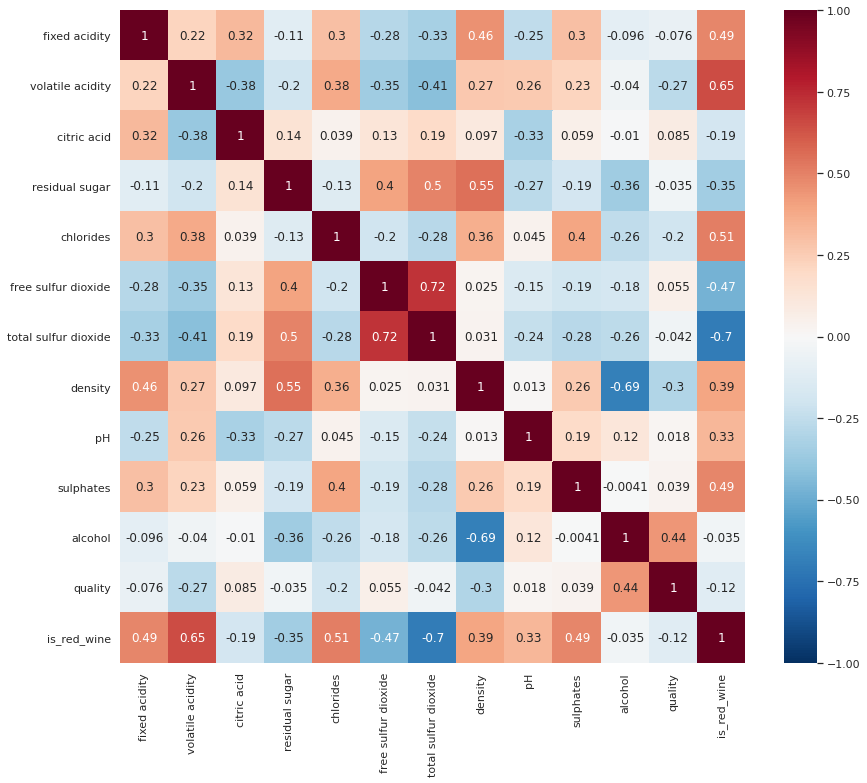

In [345]:
correlation = dataset.corr()
#display(correlation)
plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")

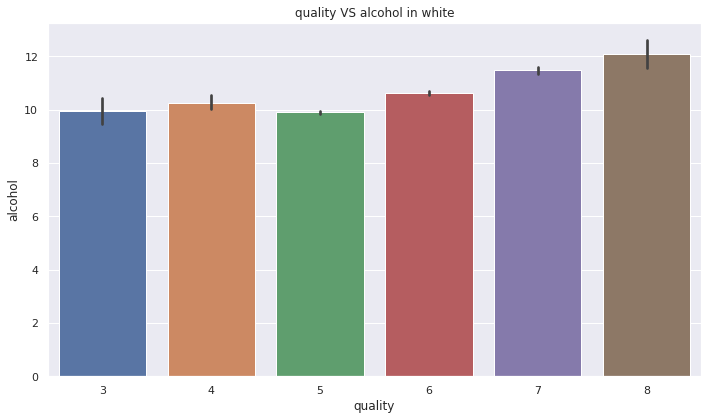

<Figure size 432x288 with 0 Axes>

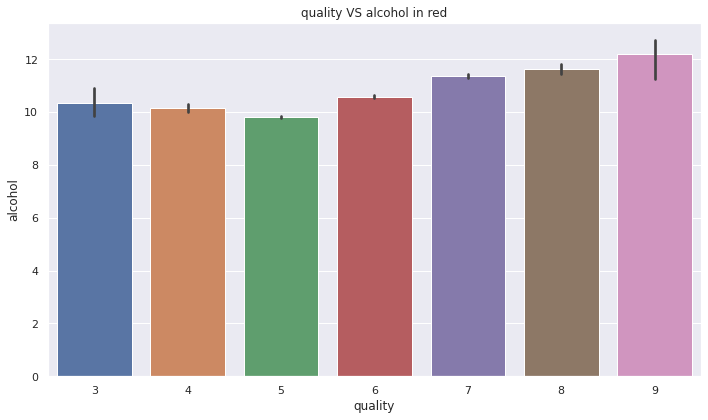

<Figure size 432x288 with 0 Axes>

In [373]:
fig, axs = plt.subplots(ncols=1,figsize=(10,6))
sns.barplot(x='quality', y='alcohol', data=dataset[dataset.type=="red"], ax=axs)
plt.title('quality VS alcohol in white')

plt.tight_layout()
plt.show()
plt.gcf().clear()

fig, axs = plt.subplots(ncols=1,figsize=(10,6))
sns.barplot(x='quality', y='alcohol', data=dataset[dataset.type=="white"], ax=axs)
plt.title('quality VS alcohol in red')

plt.tight_layout()
plt.show()
plt.gcf().clear()

Abans de començar amb els exercicis, preparem les dades per a que sigui una classificació binaria

In [374]:
#Defining the splits for categories. 1-5 will be poor quality, 6-10 will be great
bins = [1,5,10]

#0 for low quality, 1 for great quality
quality_labels=[0,1]
dataset['quality_categorical'] = pd.cut(dataset['quality'], bins=bins, labels=quality_labels, include_lowest=True)
# Split the data into features and target label
quality_raw = dataset['quality_categorical']
features_raw = dataset.drop(['type', 'quality', 'quality_categorical'], axis = 1)

In [375]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_raw, 
                                                    quality_raw, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples. {:.1f}% is positive".format(X_train.shape[0], 100*sum(y_train)/y_train.shape[0]))
print("Testing set has {} samples. {:.1f}% is positive".format(X_test.shape[0], 100*sum(y_test)/y_test.shape[0]))

display(X_test)

Training set has 5170 samples. 63.1% is positive
Testing set has 1293 samples. 64.3% is positive


fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
3859          7.300             0.250        0.260           7.200      0.048   
4675          5.700             0.210        0.370           4.500      0.040   
513           7.400             0.360        0.330           1.400      0.025   
5490          9.000             0.450        0.490           2.600      0.084   
4329          6.400             0.230        0.260           8.100      0.054   
...             ...               ...          ...             ...        ...   
410           7.200             0.250        0.390          18.950      0.038   
4562          5.600             0.180        0.300          10.200      0.028   
5626          6.400             0.570        0.020           1.800      0.067   
1248          7.200             0.180        0.310           1.100      0.045   
985           6.000             0.410        0.210           1.900      0.050   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
3859               52.000               207.000    0.996 3.120      0.370   
4675               58.000               140.000    0.993 3.290      0.620   
513                27.000                55.000    0.992 3.210      0.330   
5490               21.000                75.000    0.999 3.350      0.570   
4329               47.000               181.000    0.995 3.120      0.490   
...                   ...                   ...      ...   ...        ...   
410                42.000               155.000    1.000 2.970      0.470   
4562               28.000               131.000    0.995 3.490      0.420   
5626                4.000                11.000    0.997 3.460      0.680   
1248               20.000                73.000    0.993 3.320      0.400   
985                29.000               122.000    0.993 3.420      0.520   

      alcohol  is_red_wine  
3859    9.200            0  
4675   10.600            0  
513    11.200            0  
5490    9.700            1  
4329    9.400            0  
...       ...          ...  
410     9.000            0  
4562   10.800            0  
5626    9.500            1  
1248   10.800            0  
985    10.500            0  

[1293 rows x 12 columns]

## Logistic Regression 

En aquesta secció us demanem que apliqueu de sklearn el model de [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html):

Si feu proves amb diferents parametres, guardeu els resultats que obtingueu en una taula de pandas i els mostreu.

* Guarda resultats de temps, de precisió, de accuracy, tant de train com de test

cal veure l'efecte de 
* canviar el *learning rate*,
* el tamany del conjunt d'entrenament
* normalitzar les dades


TODO1 un cop feta aquesta funció per evaluar el model de Regressió Logística fés un anàlisi dels següents paràmetres i fes un estudi de com actuen i per què.

    penalty --> sota
    
    tol --> És el criteri d'aturada  on l'algorisme entrenarà fins que baixi la loss sota aquest llindar o que arribi al nombre d'iteracions pertinents
    
    C -->  sota
    
    random_state (per què serveix?) --> Si utilitzeu Random.state=X , llavors podeu garantir que la sortida del __train_test_split__ sempre serà iougal en totes les execucions, és a dir, que la vostra divisió serà sempre la mateixa. No importa quin sigui el nombre... L'important és que cada vegada que l'utilitzeu , sempre obtindreu la mateixa sortida la primera vegada que feu la divisió. Això és útil si voleu resultats reproduïbles
    
    
    solver --> sota
    
    
TODO2 De totes les combinacions que creguis que són les adequades per encarar la classificació amb les dades que decideixis, digues quin és el millor model que has pogut aconseguir sota el teu criteri (Utilitza les mètriques que vegis convenients)(recorda tenir en compte alguns dels paràmetres d'adalt.(tingeus en compte també el lr)

!Nota: Investiga aquest link: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

TODO3 Un cop fet l'anàlisi fes un plot de com es comporten els coeficients si afegeixes una penalització l1 o l2 amb diferents valors de C i dona una explicació del que creus que està passant.

In [335]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.metrics import accuracy_score
from time import time
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import GridSearchCV

def entrena_prediu_evalua(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: quality training set
       - X_test: features testing set
       - y_test: quality testing set
    '''
    
    results = {}
    
    """
    Fit/train the learner to the training data using slicing with 'sample_size' 
    """
    start = time() # Get start time of training
    learner.fit(X_train[:int(X_train.shape[0]*sample_size)], y_train[:int(X_train.shape[0]*sample_size)])
    end = time() # Get end time of training
    
    # Calculate the training time
    results['train_time'] = end - start
    
    """
    Get the predictions on the first 300 training samples(X_train), 
    """
    start = time() # Get start time
    predictions_train = learner.predict(X_train[:300])
    predictions_test = learner.predict(X_test)
    
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results["train_accuracy"] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results["test_accuracy"] = accuracy_score(y_test, predictions_test)
    
    # Compute F1-score on the the first 300 training samples using fbeta_score()
    results["train_F1_score"] = f1_score(y_train[:300], predictions_train)
        
    # Compute F1-score on the test set which is y_test
    results["test_F1_score"] = f1_score(y_test, predictions_test)
          
    # Return the results
    return results


# TODO 2

## *Ús del Gridsearch*

In [130]:
parameters = {'max_iter':[500, 1000], 'C':[0.01,0.1,10,100],'penalty':['l2','l1','elasticnet'],'solver':["saga", "liblinear"]}
lr = LogisticRegression()
clf_ = GridSearchCV(lr, parameters)
clf_.fit(X_train,y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 10, 100], 'max_iter': [500, 1000],
                         'penalty': ['l2', 'l1', 'elasticnet'],
                         'solver': ['saga', 'liblinear']})

In [131]:
clf_.score(X_test,y_test),clf_.score(X_train,y_train)

(0.7432327919566899, 0.7446808510638298)

In [132]:
clf_.best_score_

0.7435203094777563

In [133]:
clf_.best_params_

{'C': 100, 'max_iter': 500, 'penalty': 'l2', 'solver': 'liblinear'}

Podem veure que el buscador d'hiperparametres ens ha trobat el model que millor optimitza el error de bias i el de variança a la vegada.

En aquest cas sempre que pogueu prioritzar hiperparàmetres mireu els que són realment importants per al model. En aquest cas les penalitzacions i la C són el factor important a calcular. El cas dels solvers és important si mireu a sota havent generat un anàlisi el comportament dels solver millora o empitjora el entrenament del model. En aquest cas com que la diferència d'aplicar un solver o un altre marca més la diferència el paràmetre més important és el solver, seguit per la C.

# TODO 3

## Exemple visual de com se comporten els paràmetres C, Regularitzador i solver

In [336]:
resultats = pd.read_csv("TODO1.csv")
C_compare = pd.read_csv("TODO1_C.csv")
solver_compare = pd.read_csv("TODO1_solver.csv")

In [337]:
display(resultats)

solver     penalty         C  l1_ratio  sample_size  train_accuracy  \
0    newton-cg        none       NaN       NaN        0.400           0.760   
1    newton-cg        none       NaN       NaN        0.600           0.763   
2    newton-cg        none       NaN       NaN        0.800           0.760   
3    newton-cg        none       NaN       NaN        1.000           0.757   
4        lbfgs        none       NaN       NaN        0.400           0.760   
..         ...         ...       ...       ...          ...             ...   
555       saga  elasticnet 10000.000     0.889        1.000           0.717   
556       saga  elasticnet 10000.000     1.000        0.400           0.687   
557       saga  elasticnet 10000.000     1.000        0.600           0.687   
558       saga  elasticnet 10000.000     1.000        0.800           0.703   
559       saga  elasticnet 10000.000     1.000        1.000           0.717   

     test_accuracy  train_F1_score  test_F1_score  
0            0.742           0.815          0.805  
1            0.737           0.821          0.804  
2            0.735           0.818          0.802  
3            0.739           0.814          0.804  
4            0.739           0.815          0.802  
..             ...             ...            ...  
555          0.691           0.797          0.778  
556          0.668           0.777          0.764  
557          0.671           0.779          0.769  
558          0.684           0.791          0.776  
559          0.691           0.797          0.778  

[560 rows x 9 columns]

### * Què fa el parametre *C*.

El paràmetre *C* determina la potència de l'efecte que té el regularitzador sobre l'entrenament. En concret, quan usem un regularitzador $R(\theta)$, a la funció de pèrdua $J(\theta)$ se li suma $\frac{1}{C}R(\theta)$. És a dir, quant més alt el valor de *C* menys efecte tindrá el regularitzador (menys generarà biaix i reduirà la variància) i quant més baix el seu valor més efecte tindrà el regularitzador (mes generarà biaix i reduirà la variància).

Obviament, l'ús del paràmetre *C* en la funció LogisticRegression de sklearn afecta sempre que s'usa un regularitzador (és a dir, sempre excepte quan penalty='none').

In [11]:
display(C_compare)

C  train_accuracy  test_accuracy  train_F1_score  test_F1_score
0         0.000           0.620          0.644           0.759          0.779
1         0.001           0.677          0.650           0.786          0.772
2         0.010           0.727          0.695           0.807          0.782
3         0.100           0.753          0.724           0.820          0.796
4        10.000           0.760          0.743           0.817          0.807
5       100.000           0.763          0.746           0.819          0.809
6      1000.000           0.760          0.743           0.816          0.807
7     10000.000           0.760          0.743           0.816          0.807
8    100000.000           0.757          0.743           0.814          0.807
9   1000000.000           0.760          0.743           0.816          0.807
10 10000000.000           0.760          0.743           0.816          0.807

In [12]:
import plotly.express as px
fig = px.line(C_compare, text="C")
fig.update_traces(textposition="bottom right")
fig.show()

Observem que tant la accuracy com el F1-score de train i test creixen amb *C*, i s'estaquen a partir de $C=10$. Això pasa perque, per a valors baixos de $C$ el biaix creix massa i impedeix que el model lineal modelitzi bé la distribució de dades. 

A més, el fet que la accuracy i el F1-score s'estanquin quan fem $C$ gran (quan reduim l'efecte de la regularització) observem que no hi ha overfitting donat que train i test creixen igual. El fet de que passi això vol dir que les dades no són sorolloses i per tant no requereix regularització.

### * Descriu els diferents solvers:

    a) liblinear: s'utilitza la implementació de la biblioteca liblinear de codi obert, i el mètode de descens de l'eix intern s'utilitza per a optimitzar de manera iterativa la funció de pèrdua.

    b) lbfgs: un tipus de mètode quasi-Newton, que utilitza una segona matriu derivada de la funció de pèrdua, és a dir, una matriu de Hesse, per a optimitzar iterativament la funció de pèrdua.

    c) newton-cg: també és un tipus de família de mètodes de Newton. Utilitza la segona matriu derivada de la funció de pèrdua, és a dir, la matriu de Hesse, per a optimitzar iterativament la funció de pèrdua.

    d) Sag: Descens de gradient faig una mitjana d'aleatori, que és una variant del mètode de descens de gradient. La diferència amb el mètode de descens de gradient ordinari és que només s'usa una part de la mostra per a calcular el gradient per iteració, la qual cosa és adequat quan les dades de la mostra són grans.
    


**Pensa que no se pot utilitzar l1 amb els algorismes que impliquen derivades per que la l1 no és continua i per tant no és derivable**

In [13]:
import plotly.express as px
fig = px.line(solver_compare, text="solver")
fig.update_traces(textposition="bottom right")
fig.show()

### Quan els fem servir?

    liblinear --> liblinear és adequat per a petits conjunts de dades; si fas anat L2 i veus overfitting encara, canvia a l1 si el model té moltes característiques properes a zero o per a fer coeficients molt grans més petits.
    
    
    lbfgs/newton-cg/sag --> Para conjuntos de datos más grandes
    
    
    sag --> si realment el dataset és molt molt gran

### * Descriu el parametre **penalty** de LogisticRegression {‘l1’, ‘l2’, ‘elasticnet’, ‘none’}

Aquest parametre permet escollir si s'utilitzará o no regularitzador, i en cas afirmatiu quin regularitzador s'usarà. En concret, la opció 'none' indica que no s'usarà regularitzador, la opció 'l1' indica que s'usarà el regularitzador l1 (suma dels valors absoluts dels paràmetres del model), la opció 'l2' indica que s'usarà el regularitzador l2 (suma dels quadrats dels paràmetres del model) i la opció 'elasticnet' indica que s'utilitzarà una mescla (o fusió) dels regularitzadors l1 i l2 (en concret, $\alpha*l1\_ratio*||w||_1+\alpha*(1-l1\_ratio)*||w||^2_2$).

In [57]:
solver = 'saga'
sample_size = 1
l1_ratio = None
columnes = ["regularizer", "intercept_", "coef_"]
dades = pd.DataFrame(columns = columnes)
resultat = {key:None for key in columnes}
for penalty in ["none", "l1", "l2", "elasticnet"]:
    if penalty == "none":
        C_list = [None]
    else:
        C_list = [1e-3, 100]
    if penalty == "elasticnet":
        l1_ratio = 0.5
    
    for C in C_list:
        if C is not None:
            model = linear_model.LogisticRegression(max_iter=1000, C=C, penalty=penalty,
                                                    solver=solver, l1_ratio=l1_ratio)
        else:
            model = linear_model.LogisticRegression(max_iter=1000, penalty=penalty,
                                                    solver=solver, l1_ratio=l1_ratio)
                    
        entrena_prediu_evalua(model, sample_size, X_train, y_train, X_test, y_test)
        
        resultat["regularizer"] = penalty
        resultat["intercept_"] = model.intercept_
        resultat["coef_"] = model.coef_
        resultat["C"] = C
        
        dades = dades.append(resultat, ignore_index=True)

In [104]:
atributs = ["atribut_"+str(i) for i in range(X_train.shape[1])]
coefs = dades['coef_'].to_list()

for i in range(len(coefs)):
    coefs[i] = coefs[i].reshape(-1)

intercepts = pd.DataFrame(dades['intercept_'].to_list(), columns=['intercept'])
atributs = pd.DataFrame(coefs, columns=atributs)
Cs = pd.DataFrame(dades["C"].to_list(), columns=["C"])

newdata = pd.concat([dades['regularizer'],intercepts, atributs,Cs], axis=1, sort=False).dropna()


atributes = newdata.columns[1:-1]

colors = []
values = []
for reg in ["elasticnet", "l1", "l2"]:
    tmp = newdata.loc[newdata["regularizer"]==reg, atributes].values[0]
    colors.extend([reg for i in range(len(tmp))])
    values.extend(tmp)  
    
fig = px.bar(newdata,y=atributes,
             facet_row="C", facet_col="regularizer",barmode="group",
             category_orders={"C":[1e-3, 100], "regularizer":["elasticnet", "l1", "l2"]})

fig.update_layout(uniformtext_minsize=6)
fig.update_layout(
    title="coefs")
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",
)
fig.show()

print("Mirem com queden els diferents coeficients després de fer les regualritzacions")
display(newdata.groupby(["regularizer", "C"]).mean())


Mirem com queden els diferents coeficients després de fer les regualritzacions


intercept  atribut_0  atribut_1  atribut_2  atribut_3  \
regularizer C                                                                
elasticnet  0.001       -0.277     -0.003      0.000      0.000      0.000   
            100.000     -0.253     -0.186     -0.660      0.177      0.034   
l1          0.001        0.003      0.000      0.000      0.000      0.000   
            100.000     -0.253     -0.186     -0.660      0.177      0.034   
l2          0.001       -0.124     -0.168     -0.109      0.027      0.016   
            100.000     -0.253     -0.186     -0.660      0.177      0.034   

                     atribut_4  atribut_5  atribut_6  atribut_7  atribut_8  \
regularizer C                                                                
elasticnet  0.001        0.000      0.017     -0.006      0.000      0.000   
            100.000     -0.073      0.021     -0.011     -0.255     -0.840   
l1          0.001        0.000      0.014     -0.005      0.000      0.000   
            100.000     -0.073      0.021     -0.011     -0.255     -0.839   
l2          0.001       -0.014      0.020     -0.009     -0.038     -0.131   
            100.000     -0.073      0.021     -0.011     -0.255     -0.840   

                     atribut_9  atribut_10  atribut_11  
regularizer C                                           
elasticnet  0.001        0.000       0.103       0.000  
            100.000      0.081       0.569      -0.485  
l1          0.001        0.000       0.061       0.000  
            100.000      0.081       0.569      -0.485  
l2          0.001       -0.001       0.268      -0.123  
            100.000      0.081       0.569      -0.485

#### TORNAR-HO A MIRAR

Observem que, en general, els atributs dels models entrenats amb el regularitzador l2 tenen més valors prop de 0 que amb la lasso. La l1 penalitza més els coeficients petits per tant hi ha més valors a 0. Això s'explica perquè l'ús del regularitzador l2 afavoreix que els atributs (paràmetres del model) prenguin valors no nuls petits (ja que el quadrat fa mes petits valors per sota de valor absolut 1, i fa molt grans valors per sobre), mentre que el regularitzador l1 afavoreix que hi hagin pocs atributs no nuls (no penalitza atributs una mica grans, sempre i quant siguin pocs).

Pel que fa als paràmetres dels models entrenats amb regularització elasticnet, com era d'esperar per ser aquesta una mescla de l1 i l2, els resultats tendeixen a estar a mig camí dels obtinguts amb les dues regularitzacions.


## Multinomial 


Normalment entrenem un model d'aprenentatge automàtic per produir un sol valor o una única etiqueta com a sortida. Però quan el nombre de classes de sortida és més gran que 1, aquest és un problema de classificació multiclasse (pot passar que un problema sigui classificació multilabel, però ho veurem més endavant). Un-vs-all i un-vs-one són els dos principals enfocaments d'aprenentatge automàtic per resoldre un problema de classificació multiclasse

### One-Vs-Rest 

One-vs-rest (OvR  or One-vs-All/OvA) és un mètode heurístic per utilitzar algorismes de classificació binària per a la classificació multiclasse.

Es tracta de dividir el conjunt de dades multiclasse en múltiples problemes de classificació binària. Un classificador binari és llavors entrenat en cada problema de classificació binària i les prediccions es fan utilitzant el model amb una probabilitat més alta (arg max pel tipus de classe que és).

$$
argmax\{y_1, y_2, \cdots y_n\} | n \in \mathbb{R}
$$

### One-Vs-One

OVO divideix un conjunt de dades de classificació multiclasse en problemes de classificació binaris. A diferència de OVR que el divideix en un conjunt de dades binari per a cada classe, l'enfocament del OVO és dividir el conjunt de dades respecte a un problema de classificació binaria de tots contra tots. Per tant tenim 
$$
\frac{n * (n-1 )}{2}
$$
on n $=$ nombre de classes

Per exemple, considereu un problema de classificació multiclasse amb quatre classes: $vermell, blau, verd$ i $groc$. Això es podria dividir en sis conjunts de dades de classificació binaria:

    Binary Classification Problem 1: red vs. blue
    Binary Classification Problem 2: red vs. green
    Binary Classification Problem 3: red vs. yellow
    Binary Classification Problem 4: blue vs. green
    Binary Classification Problem 5: blue vs. yellow
    Binary Classification Problem 6: green vs. yellow
    
Tenint així 6 classificadors la sortida del final del model és 
$$
max\{{\sum_{i=1}^6 argmax[Model_i = C]}\}
$$

## Aquí tenim uns exemples molt naive per fer unes primeres proves

In [106]:
### OVR
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, n_classes=3, random_state=1)
# define model
model = LogisticRegression()
ovr = OneVsRestClassifier(model)
# fit model
ovr.fit(X, y)

yhat = ovr.predict(X[:5])
print(yhat)


[1 0 1 2 0]


In [108]:
### OVO
# define model
model = LogisticRegression()
ovr = OneVsOneClassifier(model)
# fit model
ovr.fit(X, y)

yhat = ovr.predict(X[:5])
print(yhat)


[1 2 1 2 0]


TODO1 Com a primera prova de concepte investiga quina és la sortida dels models darrera la classificació final. Realment quina forma té la sortida del OVR, és un conjunt de probabilitats? i en el OVO?

TODO2 Juga amb el make_classification per veure en quins cassos és millor el OVR i en quins el OVO, fes una taula comparativa amb diferents combinacions i treu ses teves conclusions.

TODO3 Agafa el millor model que has pogut entrenar abans i tornat al executar canviant la estratègia de classificació tenint en compte que cada qualitat és una classe. Prova les dues estratègies i torna a treure conclusions sobre quins és el millor model que pots aconseguir. Quina estratègia fa servir el Logistic Regression per defecte? Has aconseguit millors resultats?

# * TODO 1

### Tots els TODO els realitzo sobre el make classifier per a que les proves de concepte quedin més clares.

In [117]:
# Respecte a la sortida del OVR
### OVR
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, n_classes=4, random_state=1)
# define model
model = LogisticRegression()
ovr = OneVsRestClassifier(model)
# fit model
ovr.fit(X, y)
l = []
display(ovr.estimators_)
for est in ovr.estimators_:
    l.append(est.predict(X[:5]))
print("Classificacions de cada un dels classificadors interns que usa OVR")
display(np.array(l).transpose())
print(" ")

yhat = ovr.predict_proba(X[:5])
print("Agregació de les probabilitats dels classificadors")
display(yhat)



# make predictions
yhat = ovr.predict(X[:5])
print("classificació final")
display(np.array(yhat).transpose())

[LogisticRegression(),
 LogisticRegression(),
 LogisticRegression(),
 LogisticRegression()]

Classificacions de cada un dels classificadors interns que usa OVR


array([[1, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

 
Agregació de les probabilitats dels classificadors


array([[0.66199028, 0.21589153, 0.04498452, 0.07713367],
       [0.38446534, 0.0127427 , 0.39077728, 0.21201468],
       [0.37791777, 0.13472651, 0.42660353, 0.06075219],
       [0.27974239, 0.03456662, 0.57744933, 0.10824166],
       [0.01448607, 0.29695628, 0.44778858, 0.24076908]])

classificació final


array([0, 2, 2, 2, 2])

*En aquest cas la sortida del classificador del OVR ve a partir d'un procés. Primerament veiem que tot i que és una classificació multinomial el OVR ha generat 4 Logistics per a fer la predicció. Tot i que estem en un problema de classificació multinomial cada estimador és binari (1 classe vs les altres (1, 0)) per això hi han 1 i 0.*


*La següent passa és agregar la probabilitat de les classes de cada un dels estimadors que té els seus propis predict_proba i després de l'agregació finalment se queda amb el estimador amb la màxima prob agregada*

In [119]:
# define model
model = LogisticRegression()
ovo = OneVsOneClassifier(model)
# fit model
ovo.fit(X, y)
l = []
display(ovo.estimators_)
for est in ovo.estimators_:
    l.append(est.predict(X[:5]))
print("Classificacions de cada un dels classificadors interns que usa OVR")
display(np.array(l).transpose())
print(" ")

yhat = ovo.decision_function(X[:5])
print("Agregació de les probabilitats dels classificadors")
display(yhat)



# make predictions
yhat = ovo.predict(X[:5])
print("classificació final")
display(np.array(yhat).transpose())

(LogisticRegression(),
 LogisticRegression(),
 LogisticRegression(),
 LogisticRegression(),
 LogisticRegression(),
 LogisticRegression())

Classificacions de cada un dels classificadors interns que usa OVR


array([[0, 0, 0, 0, 0, 1],
       [0, 1, 1, 1, 1, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 1, 0, 1, 0, 0],
       [1, 1, 1, 1, 1, 0]])

 
Agregació de les probabilitats dels classificadors


array([[ 3.29368142,  2.21625743, -0.28489734,  0.74291451],
       [ 1.22050424, -0.29747619,  3.28216055,  2.15097951],
       [ 3.22446568,  0.80478743,  2.27447597, -0.2805229 ],
       [ 2.17972455,  0.71825767,  3.2924672 , -0.24710384],
       [-0.29272868,  1.21978311,  3.27533224,  2.11499206]])

classificació final


array([0, 2, 0, 2, 2])

*En aquest cas la sortida del classificador del OVO és diferent. Veiem en aquesta estratègia s'han generat 6 logístiques per a fer la predicció (la permutació binaria de totes amb totes com s'ha vist en s'explicació de dalt. Cada Logistic fa la predicció binaria respecte a les dues classes que està comparant.*


*La següent passa és agregar el nombre de "prediccions" que ha tingut cada classe en els seus estimadors corresponents i segons una  normalització per evitar que hi hagi "empats". Finalment el model es queda amb la classe que ha tingut "major" nombre de vots (en aquest cas normalitzat)*

### D'aquí podeu veure que el el OVO és una bona estratègia quan tens unes dades molt balancejades i sobre tot va molt be quan en tens moltes, donat que estas entrenant models molt més petits.

### Per l'altra banda en cas del OVR va be quan tens casos una mica més desbalancejats per a nivellar el aprenentatge de les classes.

# TODO 2

*Per al TODO era que agafesiu inèrcia a treballar amb escenes multiclasse. El make classifier és una bona eina per fer unes primeres proves però és dificil fer datasets competents. En aquest cas Quan el nombre de samples és molt alt amb molt poca informació que realment sigui ùtil i moltes classes el OVO teòricament hauria de ser millor. En el cas del OVR hauria de ser prou inestable sempre donat que és difícil de desnivellar el dataset amb el make classifier. Com funcionen està explicat en el TODO1 anterior*

# TODO 3

In [189]:
dataset2 = load_dataset('winequalityN.csv')
dataset2 = dataset2.dropna()
dataset2['is_red_wine'] = (dataset2["type"] == 'red').astype(int)

quality_raw2 = dataset2['quality']
features_raw2 = dataset2.drop(['type', 'quality'], axis = 1)

# Split the 'features' and 'income' data into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(features_raw2, 
                                                    quality_raw2, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

display(X_test2)

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
3859          7.300             0.250        0.260           7.200      0.048   
4675          5.700             0.210        0.370           4.500      0.040   
513           7.400             0.360        0.330           1.400      0.025   
5490          9.000             0.450        0.490           2.600      0.084   
4329          6.400             0.230        0.260           8.100      0.054   
...             ...               ...          ...             ...        ...   
410           7.200             0.250        0.390          18.950      0.038   
4562          5.600             0.180        0.300          10.200      0.028   
5626          6.400             0.570        0.020           1.800      0.067   
1248          7.200             0.180        0.310           1.100      0.045   
985           6.000             0.410        0.210           1.900      0.050   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
3859               52.000               207.000    0.996 3.120      0.370   
4675               58.000               140.000    0.993 3.290      0.620   
513                27.000                55.000    0.992 3.210      0.330   
5490               21.000                75.000    0.999 3.350      0.570   
4329               47.000               181.000    0.995 3.120      0.490   
...                   ...                   ...      ...   ...        ...   
410                42.000               155.000    1.000 2.970      0.470   
4562               28.000               131.000    0.995 3.490      0.420   
5626                4.000                11.000    0.997 3.460      0.680   
1248               20.000                73.000    0.993 3.320      0.400   
985                29.000               122.000    0.993 3.420      0.520   

      alcohol  is_red_wine  
3859    9.200            0  
4675   10.600            0  
513    11.200            0  
5490    9.700            1  
4329    9.400            0  
...       ...          ...  
410     9.000            0  
4562   10.800            0  
5626    9.500            1  
1248   10.800            0  
985    10.500            0  

[1293 rows x 12 columns]

In [185]:
print("Per defecte Logistic aplica el ovr si el problema és binary. En el seu defecte aplica una estratègia diferent en cas de multiclass")
best_model = LogisticRegression(**clf_.best_params_)
ovo = OneVsOneClassifier(best_model)
ovr = OneVsRestClassifier(best_model)

#Entrenament de les dues estratègies
ovo.fit(X_train2, y_train2)
ovr.fit(X_train2, y_train2)

#Prediccions de les dues estratègies
ovo_pred = ovo.predict(X_test2)
ovr_pred = ovr.predict(X_test2)

#show_results
print(f"Els resultats són: OVO -> {ovo.score(X_test2, y_test2): .3f}, OVR -> {ovr.score(X_test2, y_test2): .3f}")

Per defecte Logistic aplica el ovr si el problema és binary. En el seu defecte aplica una estratègia diferent en cas de multiclass
Els resultats són: OVO ->  0.538, OVR ->  0.538


In [198]:
pd.unique(y_train2)
pd.unique(y_test2)

array([5, 6, 4, 7, 8, 3])

*Podem veure que els resultats no són gaire bons, però per què?*

In [200]:
print(len(set(pd.unique(y_train2)) - set(pd.unique(y_test2))))
print("Podem veure que al test hi ha una classe menys que al train...")

1
Podem veure que al test hi ha una classe menys que al train...


## Bias and Variance

Per cert, recordeu el què significa el error de Variança i el de bias.

<img src="bias_variance.png" width=600 height=600 />


Sempre que parlem de la predicció del model, és important entendre els errors de predicció (bias i variància). Hi ha un equilibri entre la capacitat d'un model per minimitzar el biaix i la variància. La comprensió adequada d'aquests errors ens ajuda no sols a construir models més precisos, sinó també a evitar l'overfitting i el underfitteing.

## Bias

El bias és la diferència entre la predicció mitjana del nostre model i el valor correcte que estem intentant predir. El model amb un gran bias presta molt poca atenció a les dades d'entrenament i simplifica massa el model. Sempre provoca un gran error en train i test. (underfitting

## Variance


Variance és la variabilitat de la predicció del model per a un punt de dades donat. Un model amb gran variància presta molta atenció a les dades d'entrenament i no es generalitza sobre les dades de test. Com a resultat, aquests models funcionen molt bé en les dades d'entrenament, però tenen altes taxes d'error en les dades de prova, resultant, així,  l'overfitting

**Tots els TODOS d'aquí són conceptuals. Agafa els millors models que has trobat per al apartat 1 i el 2 i realitza aquests canvis per a respondre les preguntes següents.**

* TODO 1 -> Què hem de fer per veure que els models que estem provant tenen un error de bias molt alt? (es a dir, models simples)
        

* TODO 2 -> Què passa si fem servir poques dades per entrenar (utilitza el paràmetre samples de la funció anterior)? (mostra com varien els resultats segons % de entrenament)

* TODO 3 -> I si utilitzem poques iteracions limitant el *max_iter*

* TODO 4 -> Què hem de fer per veure que el model que estem provant té un error de variança molt alt? (es a dir, model massa complexe)

* TODO 5 -> Crea models de features més complexes amb [sklearn.preprocessing.PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)

* TODO 6 -> Podem reduir el error de variança si enlloc de classificar el vi blanc i el negre, els separessim?

* TODO 7 -> Sabrieu explicar-me aquesta [gráfica](https://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html)? Podeu generar-la amb aquestes dades de entrenament?



## TODO 1 i 4

*Per veure que està passant amb el model eu d'introduïr un anàlisi a dos plots molt important, un d'ells és la curva loss (loss curve) la qual te diu a cada iteraciò quina ha esta la loss (recordeu que quan més baixa vol dir que està començant a optimitzar la funció) i l'altra és la curva d'accuracy de validació i test.*


In [262]:
train_loss = np.linspace(1000, 0.005, num=100)
train_loss[30:50] = train_loss[30:50]**1.2
#test_loss = np.logspace(100, 10, num=100)
#test_loss[60:] = test_loss[60:]**2

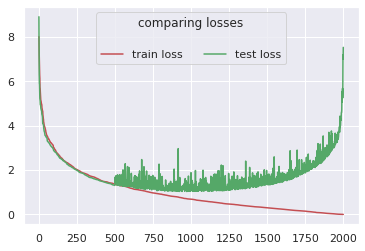

In [318]:
import numpy as np
import matplotlib.pyplot as plt

num_iters = 2000
#train
rand_curve = np.sort(np.random.exponential(size=num_iters))[::-1]
#noise  = np.random.normal(0, 0.2, num_iters)
signal = rand_curve #+ noise
noisy_curve = signal[signal > 0]
plt.plot(noisy_curve, c='r', label= "train loss")
#test
rand_test_curve = np.sort(np.random.exponential(size=num_iters))[::-1]
noisy_curve_test = rand_test_curve[rand_test_curve > 0]
noisy_curve_test[500:] += ((np.random.exponential(size=len(noisy_curve_test[500:])))/5 + np.sort(np.random.exponential(size=len(noisy_curve_test[500:]))))
plt.plot(noisy_curve_test, c='g', label= "test loss")

legend = plt.legend(title="comparing losses", ncol=2)
legend._legend_box.sep = 20
plt.show()


*En aquest cas podem veure com hi ha un error de variance molt alt i per tant sabriem que el model està sent massa complex*

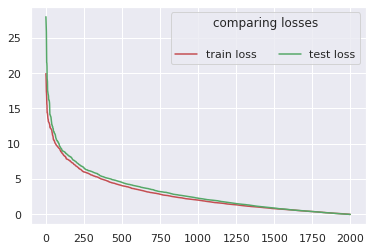

In [321]:
num_iters = 2000
#train
rand_curve = np.sort(np.random.exponential(size=num_iters))[::-1]*3
#noise  = np.random.normal(0, 0.2, num_iters)
signal = rand_curve #+ noise
noisy_curve = signal[signal > 0]
plt.plot(noisy_curve, c='r', label= "train loss")
#test
rand_test_curve = np.sort(np.random.exponential(size=num_iters))[::-1]
noisy_curve_test = rand_test_curve[rand_test_curve > 0] * 3.2
plt.plot(noisy_curve_test, c='g', label= "test loss")

legend = plt.legend(title="comparing losses", ncol=2)
legend._legend_box.sep = 20
plt.show()

*En aquest cas veiem que les magnituts són molt més altes que en el exemple anterior però que el model està generalitzant bé per tant podem dir que te un error de bias prou alt (model simple)*

# TODO 2

sample_size  train_accuracy  test_accuracy  train_F1_score  test_F1_score
0         0.025           0.753          0.718           0.809          0.782
1         0.050           0.767          0.735           0.817          0.794
2         0.075           0.763          0.712           0.812          0.771
3         0.100           0.763          0.723           0.816          0.785
4         0.125           0.753          0.728           0.808          0.791
..          ...             ...            ...             ...            ...
35        0.900           0.763          0.742           0.820          0.806
36        0.925           0.760          0.744           0.817          0.807
37        0.950           0.763          0.743           0.819          0.807
38        0.975           0.760          0.743           0.817          0.807
39        1.000           0.760          0.743           0.816          0.807

[40 rows x 5 columns]

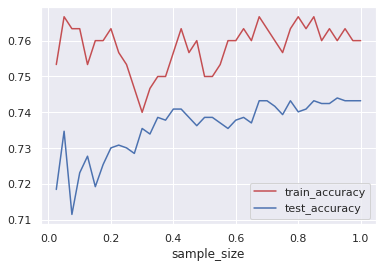

In [323]:
params = dict(resultats.iloc[resultats["test_accuracy"].argmax()].drop(
    ["sample_size", "train_accuracy", "test_accuracy", "train_F1_score", "test_F1_score"]))

outputs = ["train_accuracy", "test_accuracy", "train_F1_score", "test_F1_score"]
resultat = {}
df = pd.DataFrame(columns=["sample_size"]+outputs)

for sample_size in np.linspace(0.025, 1, 40):
    model = linear_model.LogisticRegression(**clf_.best_params_)
    out = entrena_prediu_evalua(model, sample_size, X_train, y_train, X_test, y_test)
    
    resultat["sample_size"] = sample_size
    for key in outputs:
        resultat[key] = out[key]
    
    df = df.append(resultat, ignore_index=True)

display(df)

plot1, = plt.plot(np.linspace(0.025, 1, 40), df["train_accuracy"], 'r', label="train_accuracy")
plot2, = plt.plot(np.linspace(0.025, 1, 40), df["test_accuracy"], 'b', label="test_accuracy")
plt.xlabel('sample_size')
plt.legend(handles=[plot1, plot2])
plt.show()

*Podem veure que realment el model cada vegada millora més amb més dades*

# TODO 3

max_iter  train_accuracy  test_accuracy  train_F1_score  test_F1_score
0       1.000           0.613          0.643           0.760          0.782
1       4.000           0.613          0.643           0.760          0.782
2       7.000           0.623          0.637           0.761          0.774
3      10.000           0.680          0.648           0.785          0.765
4      13.000           0.723          0.696           0.792          0.770
..        ...             ...            ...             ...            ...
105   316.000           0.760          0.743           0.816          0.807
106   319.000           0.760          0.743           0.816          0.807
107   322.000           0.760          0.743           0.816          0.807
108   325.000           0.760          0.743           0.816          0.807
109   328.000           0.760          0.743           0.816          0.807

[110 rows x 5 columns]

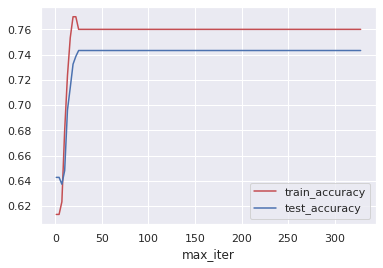

In [324]:
params = dict(resultats.iloc[resultats["test_accuracy"].argmax()].drop(
    ["sample_size", "train_accuracy", "test_accuracy", "train_F1_score", "test_F1_score"]))

outputs = ["train_accuracy", "test_accuracy", "train_F1_score", "test_F1_score"]
resultat = {}
df = pd.DataFrame(columns=["max_iter"]+outputs)

for max_iter in range(1, 331, 3):
    model = linear_model.LogisticRegression(max_iter=max_iter, **params)
    out = entrena_prediu_evalua(model, 1, X_train, y_train, X_test, y_test)
    
    resultat["max_iter"] = max_iter
    for key in outputs:
        resultat[key] = out[key]
    
    df = df.append(resultat, ignore_index=True)

display(df)

plot1, = plt.plot(range(1, 331, 3), df["train_accuracy"], 'r', label="train_accuracy")
plot2, = plt.plot(range(1, 331, 3), df["test_accuracy"], 'b', label="test_accuracy")
plt.xlabel('max_iter')
plt.legend(handles=[plot1, plot2])
plt.show()

Observem que amb poquísimes iteracions (unes 30) el model ja arriba al seu óptim.

# TODO 5

In [350]:
from sklearn.preprocessing import PolynomialFeatures
params = dict(resultats.iloc[resultats["test_accuracy"].argmax()].drop(
    ["sample_size", "train_accuracy", "test_accuracy", "train_F1_score", "test_F1_score"]))

outputs = ["train_accuracy", "test_accuracy", "train_F1_score", "test_F1_score"]
resultat = {}
df = pd.DataFrame(columns=["polynomial_degree"]+outputs)

for degree in range(4):
    poly = PolynomialFeatures(degree=degree)
    model = linear_model.LogisticRegression(**clf_.best_params_)
    out = entrena_prediu_evalua(model, 1, poly.fit_transform(X_train), y_train, poly.fit_transform(X_test), y_test)
    
    resultat["polynomial_degree"] = degree
    for key in outputs:
        resultat[key] = out[key]
    
    df = df.append(resultat, ignore_index=True)


In [355]:
df= pd.read_csv("TODO5_Part_3.csv")
display(df)

polynomial_degree  train_accuracy  test_accuracy  train_F1_score  \
0              1.000           0.760          0.743           0.816   
1              2.000           0.773          0.746           0.827   
2              3.000           0.793          0.725           0.843   
3              4.000           0.783          0.724           0.839   
4              5.000           0.740          0.711           0.814   
5              6.000           0.730          0.708           0.807   

   test_F1_score  
0          0.807  
1          0.809  
2          0.797  
3          0.801  
4          0.797  
5          0.795

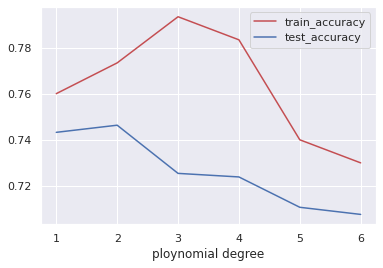

In [354]:
plot1, = plt.plot(range(1,7), df["train_accuracy"], 'r', label="train_accuracy")
plot2, = plt.plot(range(1,7), df["test_accuracy"], 'b', label="test_accuracy")
plt.xlabel('ploynomial degree')
plt.legend(handles=[plot1, plot2])
plt.show()

*En aquest cas no podem veure que hi hagi una millora significativa*

# TODO 6 

In [360]:
white_df = dataset[dataset.is_red_wine==0]
red_df = dataset[dataset.is_red_wine==1]

quality_raw = white_df['quality']
features_raw = white_df.drop(['quality_categorical','type','quality'],axis=1)
quality_raw2 = red_df['quality']
features_raw2 = red_df.drop(['quality_categorical','type','quality'],axis=1)
X_train_white, X_test_white, y_train_white, y_test_white = train_test_split(features_raw, 
                                                    quality_raw, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(features_raw2, 
                                                    quality_raw2, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

#blanc
lr_w = LogisticRegression(**clf_.best_params_)

ovo_w = OneVsOneClassifier(lr_w)
ovr_w = OneVsRestClassifier(lr_w)

ovo_w.fit(X_train_white,y_train_white)
ovr_w.fit(X_train_white,y_train_white)

#rosat
lr_r = LogisticRegression(**clf_.best_params_)
ovo_r = OneVsOneClassifier(lr_r)
ovr_r = OneVsRestClassifier(lr_r)

ovo_r.fit(X_train_red,y_train_red)
ovr_r.fit(X_train_red,y_train_red)
print(f'Accuracy (sobre testing) del vi blanc: OVO: {ovo_w.score(X_test_white,y_test_white): .3f} OVR: {ovr_w.score(X_test_white,y_test_white): .3f}')
print(f'Accuracy (sobre testing) del vi rosat: OVO: {ovo_r.score(X_test_red,y_test_red): .3f} OVR: {ovr_r.score(X_test_red,y_test_red): .3f}')


Accuracy (sobre testing) del vi blanc: OVO:  0.553 OVR:  0.548
Accuracy (sobre testing) del vi rosat: OVO:  0.583 OVR:  0.580


**Podem veure que aquests resultats són una mica millors que en els intentas anteriors, sobre tot en el rosat.** 

# TODO 7

En aquesta gràfica veiem els valors que prenen els coeficients del model si, aplicant regularització l2, anem modificant el paràmetre de regularització $\alpha=\frac{1}{C}$ (cada coeficient té associat un color). 

Observem com per a valors de $\alpha$ alts (començant per $\alpha=10^{-3}$) el regularitzador té bastant pes dins la funció de pèrdua i per tant (com hem explicat abans) els valors dels paràmetres tendeixen a concentrarse dins l'intèrval $[-1, 1]$. Per contra, a mesura que el valor de $\alpha$ va disminuint, el pes del regularitzador dins de la funció de loss va disminuint fins a ser pràcticament nul, i per tant augmenten tant la variància com el valor absolut dels paràmetres.


*Codi per reproduïr la imatge*

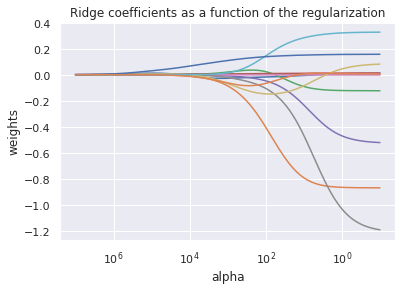

In [368]:
n_alphas = 200
alphas = np.logspace(-1, 7, n_alphas)

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()